In [1]:
import datetime
import os
from random import shuffle
import traceback
from typing import Union, List
import numpy as np
import pickle

import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt.efficient_frontier import EfficientFrontier

from pypfopt import EfficientSemivariance
#from pypfopt import EfficientCVaR

from rl_mestrado.stock.Stock import Stock
import ffn.core as ffn
import bt

from tsmoothie.smoother import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')
# plots of BT only work with this following command
%matplotlib inline

In [2]:
def save_to_pickle(path, variables):
    """Salva variáveis em arquivo .pickle
    
    Arguments:
        path {str}-- Caminho do arquivo 
        variables {list} -- Lista de variáveis a serem salvas 
    """
    with open(path, 'wb') as f:
        pickle.dump(variables, f)

def return_from_pickle(path):
    """Retorna variáveis de um arquivo .pickle
    
    Arguments:
        path {str}-- Caminho do arquivo 
    
    Returns:
        variables {list} -- Lista de variáveis
    """
    with open(path, 'rb') as f:
        # log(text = "Variables returned from path {}".format(path))
        return pickle.load(f)

In [3]:
# calculate probabilistic momentum between returns series of two assets (ex. market x bonds)
# probabilistic momentum can be defined as the probability or confidence that one asset (left) is going to outperform the other (right).
# lookback period: n days (not business days)
# p_currentDate = reference date - usually the current date 
def checkForProbMomentum(p_returns:pd.DataFrame, left_ticker: str, right_ticker: str, 
                         p_currentDate=pd.Timestamp, p_lookbackPeriod=66):
    
    v_startDate = p_currentDate - pd.DateOffset(days=p_lookbackPeriod)
    v_returns = p_returns.loc[ v_startDate:p_currentDate, [left_ticker,right_ticker] ]
        
    v_leftReturns = v_returns.iloc[:,0]
    v_rightReturns = v_returns.iloc[:,1]
        
    mom = ffn.calc_prob_mom(v_leftReturns, v_rightReturns)
     
    return mom       

In [4]:
def getSmoothedReturns(p_returns: pd.DataFrame, p_smooth_fraction: float = 0.50):
     
    v_smoothed_returns = pd.DataFrame(index=p_returns.index)
    smoother = SpectralSmoother(smooth_fraction=p_smooth_fraction, pad_len=20)
    for i_name in p_returns.columns:
        i_returns = p_returns[i_name].dropna()
        # spectral smoother does not works if the number of data points is odd
        if ( len(i_returns.index) % 2 ) != 0:
            i_returns = i_returns[1:]              # remove the first row in case of odd number of points
        smoother.smooth(i_returns.values)
        i_returns_smooth_array = smoother.smooth_data[0][:]
        i_returns_smooth_series = pd.Series(i_returns_smooth_array, index=i_returns.index, name=i_returns.name)
        v_smoothed_returns = pd.concat([v_smoothed_returns, i_returns_smooth_series], axis=1)
        
    return v_smoothed_returns 

In [5]:
def getBuyAndHoldStrategyReturns(p_returnsDf: pd.DataFrame, p_weightsDf: pd.DataFrame):
    
    indexes_list = list(p_returnsDf.index) + list(p_weightsDf.index)       # merge the indexes (timestamps) of the weights and returns Dataframes into a list
    indexes_set = set(indexes_list)                                        # remove the repeated indexes
    indexes_set = sorted(indexes_set)                                      # sort the indexes 
    v_weightsRdxDf = p_weightsDf.reindex(indexes_set, method='pad')  # reindexes weight DF with the following filling logic: propagate last valid observation forward to next valid 
    v_weightsRdxDf = v_weightsRdxDf.reindex(p_returnsDf.index)       #  reindexes weight DF according to the returns DF indexes
    # calculates pd.Series representing the daily total returns for the strategy
    calc = (p_returnsDf * v_weightsRdxDf)
    v_totalRetSeries = calc.sum(axis=1) + 1
    # get the daily cumulative return (pd.Series) for the strategy
    v_totalRetSeries.iloc[0] = 1                 # 1 + Ret_{port,t=0} = 1 - the total return for the timestamp t=0 is 1 
    v_cumRetSeries = v_totalRetSeries.cumprod()
    
    return v_totalRetSeries, v_cumRetSeries

In [6]:
def PyPortfolioOptimize(p_etfs: List[Stock], 
                        p_weeklyReturns:pd.DataFrame,
                        p_dateFrom: pd.Timestamp, p_dateTo: pd.Timestamp, 
                        p_minAssetLength: int = 66,
                        p_priceFiltering: bool = False, p_smoothingFactor: float = 0.75,
                        p_inSamplePeriod: int = 365, p_rollingPeriod: str = 'weekly', 
                        p_method: str = 'minVolatility',  p_maxBound: float = 1.0, 
                        verbose=True, p_solver: str = 'ECOS'):
    
    v_dateFromOutSample = p_dateFrom                                                     # ex: 2010-01-01
    v_dateToInSample = v_dateFromOutSample - pd.DateOffset(days=1)                       # ex: 2009-12-31  
    v_dateFromInSample = v_dateFromOutSample - pd.DateOffset(days=p_inSamplePeriod)     # ex: 2010-01-01 - 2 years = 2008-01-01  

    v_allEtfPricesDf = Stock.getAssetsAggregatedDf(p_etfs)                              # dataframe of etf's historical prices - etfs per columns
    v_allEtfReturnsDf = Stock.getAssetsReturnsDf(p_etfs, p_fillNa=False)                # dataFrame of returns for all universe of etfs - etfs per columns
    v_allEtfsIds = [a.id for a in p_etfs]
        
    v_weightsDf = pd.DataFrame(columns=v_allEtfsIds)                                # dataframe of portfolio weights - etfs per columns
    
    
    while (v_dateFromOutSample < p_dateTo):                                          
        
        #print(f'DEBUGGING for in-sample period: {v_dateFromInSample} -- {v_dateToInSample}')
             
        
        ### ------------------- Mandatory Steps of Asset Selection (pre-optimization steps)
        i_selectedEtfs = p_etfs   
        
        # remove assets that started after the last day of the in-sample period (v_dateToInSample); 
        # in addition, remove assets that started before the last day of the in-sample period but do not have enough days (p_minAssetLenght = 66 by default)
        # to be considered in the optimization process  
        i_removedEtfs = [a.id for a in i_selectedEtfs if len(a.dataFrame.loc[:v_dateToInSample]) < p_minAssetLength]   
        i_selectedEtfs = [a for a in i_selectedEtfs if a.id not in i_removedEtfs]
        #print(f'List of removed ETfs: {i_removedEtfs}')
        
        i_etfsIds = [s.id for s in i_selectedEtfs]
        v_etfPricesDf = v_allEtfPricesDf.loc[v_dateFromInSample:v_dateToInSample, i_etfsIds]
        v_etfReturnsDf = v_allEtfReturnsDf.loc[v_dateFromInSample:v_dateToInSample, i_etfsIds]
        
        v_pricesDf = v_etfPricesDf
        v_returnsDf = v_etfReturnsDf
            
        # removing RICs with NaN values 
        #v_pricesDf.dropna(axis='columns',inplace=True)
        
        #print(f'Number of RICs que restaram apos Procedimentos de Selecao e Filtragem (Remocao de Assets): {len(i_stocksIds)}')
        #v_pricesDf.info()
        
        # checking for columns (assets) having some NAN values 
        #bool_NAN_pricesDf = v_pricesDf.isnull().sum() > 0

        # printing the assets having NAN values  
        #v_NAN_assetList = [i for i in bool_NAN_pricesDf.index if bool_NAN_pricesDf[i]]
        #for i_asset in v_NAN_assetList:
           # print(f'asset: {i_asset}, total of non-NaN values: {v_pricesDf[i_asset].count()}')
            #print(f'asset: {i_asset}, number of NaN values: {v_pricesDf[i_asset].isna().sum()}')
        
        ### -------------- getting the portfolio (weight vector) for the corresponding insample period        
        
        if verbose == True:
            print(f'Starting calculating weights for period from: {v_dateFromInSample} to {v_dateToInSample}')
            print(f'SOLVER: {p_solver}')
            
        if p_priceFiltering:
            # estimating expected returns - returns a pd.Series that has the annualised mean (daily) return for each asset
            # drop NAN values if necessary 
            v_returnsDf_smoothed = getSmoothedReturns(p_returns=v_returnsDf, p_smooth_fraction=p_smoothingFactor)
            i_mu = expected_returns.mean_historical_return(v_returnsDf_smoothed, returns_data=True).dropna()
            # check if necessary to drop an asset from dataframe of historical prices
            dif = list(v_returnsDf_smoothed.columns.difference(i_mu.index))
            v_returnsDf_smoothed = v_returnsDf_smoothed.drop(dif, axis=1)
            i_S = risk_models.risk_matrix(v_returnsDf_smoothed, returns_data=True, method='ledoit_wolf_constant_variance')
        else:
            # estimating expected returns - returns a pd.Series that has the annualised mean (daily) return for each asset
            # drop NAN values if necessary 
            i_mu = expected_returns.mean_historical_return(v_pricesDf).dropna()      
            # check if necessary to drop an asset from dataframe of historical prices
            dif = list(v_pricesDf.columns.difference(i_mu.index))
            v_pricesDf = v_pricesDf.drop(dif, axis=1)
            # estimating covariance matrix - calculate the Ledoit-Wolf shrinkage estimate for a particular shrinkage target.
            i_S = risk_models.risk_matrix(v_pricesDf, method='ledoit_wolf_constant_variance')
            
        # Optimization Stage
        p_bounds = (0, 1)
        i_ef = EfficientFrontier(i_mu, i_S, weight_bounds=p_bounds, solver=p_solver, verbose=False)
        
        # -------------------------------------------------------------------------------------------------
        # calculate probabilistic momentum between market (SPY) x bonds (TAIL or TLT)
        tlt_index = i_ef.tickers.index("TLT.O")
        spy_index = i_ef.tickers.index("SPY")
        xlk_index = i_ef.tickers.index("XLK")
        #gld_index = i_ef.tickers.index("GLD")
        if 'TAIL.K' in v_returnsDf.columns:
            tail_index = i_ef.tickers.index("TAIL.K")
            mom_market = checkForProbMomentum(p_weeklyReturns, 'SPY', 'TAIL.K', v_dateToInSample, p_lookbackPeriod=60)
        else:
            mom_market = checkForProbMomentum(p_weeklyReturns, 'SPY', 'TLT.O', v_dateToInSample, p_lookbackPeriod=60)
        
        print(f'Market Momentum for {v_dateToInSample}: {mom_market}')
        if mom_market > 0.5:
            # add constraints
            i_ef.add_constraint(lambda w: w[:] <= p_maxBound)          
            i_ef.add_constraint(lambda w: w[tlt_index] == 0.00)
            #i_ef.add_constraint(lambda w: w[gld_index] == 0.00)
            if 'TAIL.K' in v_returnsDf.columns:
                i_ef.add_constraint(lambda w: w[tail_index] == 0.00)
            i_ef.add_constraint(lambda w: w[xlk_index] >= 0.50)
                    
        elif mom_market <= 0.5:
            # add constraints
            if 'TAIL.K' in v_returnsDf.columns:
                i_ef.add_constraint(lambda w: w[tlt_index] == 0.00)
                i_ef.add_constraint(lambda w: w[tail_index] >= 0.50)
                #i_ef.add_constraint(lambda w: w[gld_index] >= 0.20)
            elif 'TAIL.K' not in v_returnsDf.columns:
                i_ef.add_constraint(lambda w: w[tlt_index] >= 0.50)
                #i_ef.add_constraint(lambda w: w[gld_index] >= 0.20)
               
        if p_method == 'maxSharpe':
            i_weights = i_ef.max_sharpe(risk_free_rate=0)
        elif p_method == 'minVolatility':
            i_weights = i_ef.min_volatility()
        
        # post-processing weights
        v_cleaned_weights = i_ef.clean_weights()
        v_weightsSeries = pd.Series(v_cleaned_weights)
        
        print(v_weightsSeries [v_weightsSeries > 0])
        print(f'-------------------------------------------------------------\n\n\n')
        
        ### -------------- getting the portfolio (weight vector) for the corresponding insample period        
        
        v_portSymbols = [s for s in v_weightsSeries.index]
        
        # the reference date for the optimized portfolio is the start date of the Out of Sample period (v_dateFromOutSample)
        i_weightsIndex = v_dateFromOutSample
        v_weightsDf.loc[i_weightsIndex, :] = 0
        # assign the portfolio weights to the dataframe in the corresponding date
        for i_symbol in v_portSymbols:
            v_weightsDf.loc[i_weightsIndex, i_symbol] = v_weightsSeries.loc[i_symbol]
        
        
        ### ----------------- update to the next insample period
        if p_rollingPeriod == 'monthly':
            v_dateFromOutSample = v_dateFromOutSample + pd.DateOffset(months=1)
        elif p_rollingPeriod == 'weekly':
            v_dateFromOutSample = v_dateFromOutSample + pd.DateOffset(weeks=1)
        elif p_rollingPeriod == 'quarterly':
            v_dateFromOutSample = v_dateFromOutSample + pd.DateOffset(months=3)
        
        v_dateFromInSample = v_dateFromOutSample - pd.DateOffset(days=p_inSamplePeriod)
        v_dateToInSample = v_dateFromOutSample - pd.DateOffset(days=1)
        
    # end while
    
    if verbose == True:
        print(f'Optimization Finished!\n')

    # -----------------------
    # get the slice of the dataFrame of returns corresponding to the backtesting period (ex: v_dateFrom: 2010-01-01 - v_dateTo: 2020-11-23)
    
    v_etfReturnsDf = v_allEtfReturnsDf.loc[p_dateFrom:p_dateTo]
    
    v_totalRetSeries, v_cumRetSeries = getBuyAndHoldStrategyReturns(v_etfReturnsDf,v_weightsDf)
    
    return v_cumRetSeries 

    

In [7]:
# get all ETFs (daily prices)

# get a list of Stocks (object) from Eikon US - folder containing all ETFs -> p_exchange='US_ETFs'
p_folderName='US_ETFs'    # name of folder where the database is kept 
v_etfsList = Stock.getStocksFromFiles(p_database='eikon', p_number=None, p_exchange=p_folderName, p_shuffle=False, data_path='../data')

# select which ETFs from the ETF universe will participate of the strategy 
v_ricList = ['SPY', 'TLT.O', 'TAIL.K', 'XLK']
v_etfsSelList = [a for a in v_etfsList if a.id in v_ricList]

df_prices = Stock.getAssetsAggregatedDf(p_assetsList = v_etfsSelList, p_column = 'close')

df_prices

,SPY,TAIL.K,TLT.O,XLK
2002-01-02,115.53,NaN,NaN,24.60
2002-01-03,116.84,NaN,NaN,25.68
2002-01-04,117.62,NaN,NaN,25.84
2002-01-07,116.79,NaN,NaN,25.56
2002-01-08,116.52,NaN,NaN,25.75
...,...,...,...,...
2021-09-24,443.91,18.4900,146.91,156.71
2021-09-27,442.64,18.4900,146.37,155.19
2021-09-28,433.72,18.6500,144.09,150.59
2021-09-29,434.45,18.6301,144.34,150.40


In [8]:
# weekly returns - will be used only for computing the probabilistic momentum between market (SPY) and bonds (TLT or TAIL)
df_weeklyPrices = pd.read_csv('../raw/raw_weekly_prices.csv', parse_dates=True, index_col=0)
df_weeklyReturns = df_weeklyPrices.pct_change(axis=0)
df_weeklyReturns

,XLK,SPY,TLT.O,TAIL.K,VIX
2002-01-04,NaN,NaN,NaN,NaN,NaN
2002-01-11,0.003416,-0.005857,NaN,NaN,0.031256
2002-01-18,-0.035899,-0.018779,NaN,NaN,0.032834
2002-01-25,-0.039151,-0.005444,NaN,NaN,-0.043122
2002-02-01,-0.003689,-0.007196,NaN,NaN,0.012390
...,...,...,...,...,...
2021-09-03,0.010492,0.009466,-0.000523,-2.664961e-03,-0.055446
2021-09-10,-0.005389,-0.007017,-0.005454,9.619496e-04,0.161918
2021-09-17,-0.008635,-0.008365,0.011906,3.256807e-03,0.017904
2021-09-24,-0.015005,-0.015526,-0.001440,-2.220446e-16,0.112009


In [9]:
# define the period of Backtesting 
v_dateFrom = pd.Timestamp('2015-01-05')          # should be a monday  
v_dateFromStr = v_dateFrom.strftime('%Y-%m-%d')
v_dateTo = pd.Timestamp('2021-09-30')
v_dateToStr = v_dateTo.strftime('%Y-%m-%d')

# ------------------------------------------------------
# strategy parameters 

# assets selection
v_priceFiltering = True                # flag that activates filtering of the historical prices dataFrame (via tsmoothie)
v_smoothingFactor = 0.75
v_minAssetLength = 66                  # minimum sample size (days) to be considered in the optimization process (in business days)

# portfolio optimization
v_solver = 'ECOS'
#v_solver = 'OSQP'
#v_solver = 'SCS'
v_inSamplePeriod = 365*2                # 2 years
#v_rollingPeriod = 'monthly'                  
#v_rollingPeriod = 'quarterly'
v_rollingPeriod = 'weekly'             
v_method = ['minVolatility','maxSharpe']
#v_method = ['minVolatility']
v_maxBound = 1.0                # max bound for stock weights in the portfolio

# strategy properties
v_strategyProperties = f'LongOnly_From_{v_dateFromStr}_To_{v_dateToStr}' \
+ f'_Model_MeanVariance' \
+ f'_{"PriceFiltering" if v_priceFiltering else "NoPriceFiltering"}' \
+ f'{v_smoothingFactor if v_priceFiltering else ""}' \
+ f'_InSmp{v_inSamplePeriod}d_Roll{v_rollingPeriod}' 

print(v_strategyProperties)

v_savingPath=f'Backtesting_Files/{v_strategyProperties}.pkl'

strategies_dict = {}
v_errors = []

for i_method in v_method:
        
    if i_method == 'minVolatility':
        i_metStr = 'minVol'
    elif i_method == 'maxSharpe':
        i_metStr = i_method
    keyName =  f'{i_metStr}'
        
    try:
        print(f'--------------------------------------------------------------\n')
        print(f'Starting Backtesting from {v_dateFrom} to {v_dateTo}\n')
        print(f'Strategy Name: {keyName} - Solver: {v_solver} \n')
        print(f'--------------------------------------------------------------\n')

        v_cumReturnsSeries = PyPortfolioOptimize(p_etfs=v_etfsSelList,
                                                 p_weeklyReturns = df_weeklyReturns,
                                                 p_dateFrom=v_dateFrom,
                                                 p_dateTo=v_dateTo,
                                                 p_priceFiltering=v_priceFiltering,
                                                 p_smoothingFactor=v_smoothingFactor, 
                                                 p_minAssetLength=v_minAssetLength,  
                                                 verbose=True,
                                                 p_inSamplePeriod=v_inSamplePeriod,
                                                 p_rollingPeriod=v_rollingPeriod,
                                                 p_method=i_method,
                                                 p_maxBound=v_maxBound,
                                                 p_solver = v_solver)
        # if optimization was successfull, then insert strategy's cumulative returns into dict 
        strategies_dict[keyName] = v_cumReturnsSeries
    
    except:
        traceback.print_exc()
        print(f'Error for {keyName}')
        v_errors.append(keyName)
            
              
print(f'Errors for portfolios: {v_errors}')

#save_to_pickle(v_savingPath, strategies_dict)


LongOnly_From_2015-01-05_To_2021-09-30_Model_MeanVariance_PriceFiltering0.75_InSmp730d_Rollweekly
--------------------------------------------------------------

Starting Backtesting from 2015-01-05 00:00:00 to 2021-09-30 00:00:00

Strategy Name: minVol - Solver: ECOS 

--------------------------------------------------------------

Starting calculating weights for period from: 2013-01-05 00:00:00 to 2015-01-04 00:00:00
SOLVER: ECOS
Market Momentum for 2015-01-04 00:00:00: 0.4752359536288395
SPY      0.38708
TLT.O    0.50000
XLK      0.11292
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-01-12 00:00:00 to 2015-01-11 00:00:00
SOLVER: ECOS
Market Momentum for 2015-01-11 00:00:00: 0.3649818807264693
SPY      0.38666
TLT.O    0.50000
XLK      0.11334
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-01-19 00:00:00 to 2015-01-18

Market Momentum for 2015-08-23 00:00:00: 0.3464650483213394
SPY      0.5
TLT.O    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-08-31 00:00:00 to 2015-08-30 00:00:00
SOLVER: ECOS
Market Momentum for 2015-08-30 00:00:00: 0.24224688162828284
SPY      0.5
TLT.O    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-09-07 00:00:00 to 2015-09-06 00:00:00
SOLVER: ECOS
Market Momentum for 2015-09-06 00:00:00: 0.32614884784872344
SPY      0.5
TLT.O    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-09-14 00:00:00 to 2015-09-13 00:00:00
SOLVER: ECOS
Market Momentum for 2015-09-13 00:00:00: 0.378261485893057
SPY      0.5
TLT.O    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights 

SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-04-05 00:00:00 to 2016-04-03 00:00:00
SOLVER: ECOS
Market Momentum for 2016-04-03 00:00:00: 0.5655246560868643
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-04-12 00:00:00 to 2016-04-10 00:00:00
SOLVER: ECOS
Market Momentum for 2016-04-10 00:00:00: 0.5594479014087944
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-04-19 00:00:00 to 2016-04-17 00:00:00
SOLVER: ECOS
Market Momentum for 2016-04-17 00:00:00: 0.7381268293053398
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-04-26 00:00:00 to 2016-04-24 00:00:00
SOLVER: ECOS
Mark

Market Momentum for 2016-11-13 00:00:00: 0.6388449750175229
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-11-22 00:00:00 to 2016-11-20 00:00:00
SOLVER: ECOS
Market Momentum for 2016-11-20 00:00:00: 0.6738305274104951
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-11-29 00:00:00 to 2016-11-27 00:00:00
SOLVER: ECOS
Market Momentum for 2016-11-27 00:00:00: 0.7115061264165098
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-12-06 00:00:00 to 2016-12-04 00:00:00
SOLVER: ECOS
Market Momentum for 2016-12-04 00:00:00: 0.75151086197219
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 20

SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-06-27 00:00:00 to 2017-06-25 00:00:00
SOLVER: ECOS
Market Momentum for 2017-06-25 00:00:00: 0.5262074780939265
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-07-04 00:00:00 to 2017-07-02 00:00:00
SOLVER: ECOS
Market Momentum for 2017-07-02 00:00:00: 0.4294779555614695
SPY      0.46246
TLT.O    0.53754
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-07-11 00:00:00 to 2017-07-09 00:00:00
SOLVER: ECOS
Market Momentum for 2017-07-09 00:00:00: 0.4747005603057941
SPY      0.45921
TLT.O    0.54079
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-07-18 00:00:00 to 2017-07-16 00

SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-02-06 00:00:00 to 2018-02-04 00:00:00
SOLVER: ECOS
Market Momentum for 2018-02-04 00:00:00: 0.8555384362809422
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-02-13 00:00:00 to 2018-02-11 00:00:00
SOLVER: ECOS
Market Momentum for 2018-02-11 00:00:00: 0.5015867227920081
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-02-20 00:00:00 to 2018-02-18 00:00:00
SOLVER: ECOS
Market Momentum for 2018-02-18 00:00:00: 0.5387391462967531
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-02-27 00:00:00 to 2018-02-25 00:00:00
SOLVER: ECOS
Mark

Market Momentum for 2018-09-02 00:00:00: 0.810776455165678
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-09-10 00:00:00 to 2018-09-09 00:00:00
SOLVER: ECOS
Market Momentum for 2018-09-09 00:00:00: 0.7451556189454365
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-09-17 00:00:00 to 2018-09-16 00:00:00
SOLVER: ECOS
Market Momentum for 2018-09-16 00:00:00: 0.7342037543672764
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-09-24 00:00:00 to 2018-09-23 00:00:00
SOLVER: ECOS
Market Momentum for 2018-09-23 00:00:00: 0.739679892537032
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 20

Market Momentum for 2019-05-12 00:00:00: 0.6019175445112483
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-05-20 00:00:00 to 2019-05-19 00:00:00
SOLVER: ECOS
Market Momentum for 2019-05-19 00:00:00: 0.5239471272988073
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-05-27 00:00:00 to 2019-05-26 00:00:00
SOLVER: ECOS
Market Momentum for 2019-05-26 00:00:00: 0.5047618051527429
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-06-03 00:00:00 to 2019-06-02 00:00:00
SOLVER: ECOS
Market Momentum for 2019-06-02 00:00:00: 0.46249438571853985
SPY       0.5
TAIL.K    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period

SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-01-06 00:00:00 to 2020-01-05 00:00:00
SOLVER: ECOS
Market Momentum for 2020-01-05 00:00:00: 0.7992930673587901
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-01-13 00:00:00 to 2020-01-12 00:00:00
SOLVER: ECOS
Market Momentum for 2020-01-12 00:00:00: 0.7747752846863047
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-01-20 00:00:00 to 2020-01-19 00:00:00
SOLVER: ECOS
Market Momentum for 2020-01-19 00:00:00: 0.7875019288687641
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-01-27 00:00:00 to 2020-01-26 00:00:00
SOLVER: ECOS
Mark

SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-09-01 00:00:00 to 2020-08-30 00:00:00
SOLVER: ECOS
Market Momentum for 2020-08-30 00:00:00: 0.924111919448009
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-09-08 00:00:00 to 2020-09-06 00:00:00
SOLVER: ECOS
Market Momentum for 2020-09-06 00:00:00: 0.8947693583301619
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-09-15 00:00:00 to 2020-09-13 00:00:00
SOLVER: ECOS
Market Momentum for 2020-09-13 00:00:00: 0.6533016344781999
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-09-22 00:00:00 to 2020-09-20 00:00:00
SOLVER: ECOS
Marke

SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2019-05-11 00:00:00 to 2021-05-09 00:00:00
SOLVER: ECOS
Market Momentum for 2021-05-09 00:00:00: 0.8042230494210605
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2019-05-18 00:00:00 to 2021-05-16 00:00:00
SOLVER: ECOS
Market Momentum for 2021-05-16 00:00:00: 0.7055334315953807
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2019-05-25 00:00:00 to 2021-05-23 00:00:00
SOLVER: ECOS
Market Momentum for 2021-05-23 00:00:00: 0.6647545976804343
SPY    0.5
XLK    0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2019-06-01 00:00:00 to 2021-05-30 00:00:00
SOLVER: ECOS
Mark

SPY    0.26627
XLK    0.73373
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-04-20 00:00:00 to 2015-04-19 00:00:00
SOLVER: ECOS
Market Momentum for 2015-04-19 00:00:00: 0.5046675290225379
SPY    0.21993
XLK    0.78007
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-04-27 00:00:00 to 2015-04-26 00:00:00
SOLVER: ECOS
Market Momentum for 2015-04-26 00:00:00: 0.4503840745454688
TLT.O    0.5
XLK      0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-05-04 00:00:00 to 2015-05-03 00:00:00
SOLVER: ECOS
Market Momentum for 2015-05-03 00:00:00: 0.5414564616324506
SPY    0.15479
XLK    0.84521
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-05-11 00:00:00 to 2015-05-1

Market Momentum for 2015-11-15 00:00:00: 0.6044390408418141
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-11-23 00:00:00 to 2015-11-22 00:00:00
SOLVER: ECOS
Market Momentum for 2015-11-22 00:00:00: 0.5750276852939415
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-11-30 00:00:00 to 2015-11-29 00:00:00
SOLVER: ECOS
Market Momentum for 2015-11-29 00:00:00: 0.6351719575089674
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-12-07 00:00:00 to 2015-12-06 00:00:00
SOLVER: ECOS
Market Momentum for 2015-12-06 00:00:00: 0.710059787905998
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2013-12-14 00:00:00 to 2015-12-13 00:00:00
SO

Market Momentum for 2016-07-31 00:00:00: 0.4422530651942939
TLT.O    0.58414
XLK      0.41586
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-08-09 00:00:00 to 2016-08-07 00:00:00
SOLVER: ECOS
Market Momentum for 2016-08-07 00:00:00: 0.458008424239163
TLT.O    0.55347
XLK      0.44653
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-08-16 00:00:00 to 2016-08-14 00:00:00
SOLVER: ECOS
Market Momentum for 2016-08-14 00:00:00: 0.4782891086437747
TLT.O    0.55935
XLK      0.44065
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2014-08-23 00:00:00 to 2016-08-21 00:00:00
SOLVER: ECOS
Market Momentum for 2016-08-21 00:00:00: 0.5458181775703843
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating w

XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-04-11 00:00:00 to 2017-04-09 00:00:00
SOLVER: ECOS
Market Momentum for 2017-04-09 00:00:00: 0.5381048466743287
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-04-18 00:00:00 to 2017-04-16 00:00:00
SOLVER: ECOS
Market Momentum for 2017-04-16 00:00:00: 0.5104648182719106
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-04-25 00:00:00 to 2017-04-23 00:00:00
SOLVER: ECOS
Market Momentum for 2017-04-23 00:00:00: 0.4085195660701387
TLT.O    0.5
XLK      0.5
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-05-02 00:00:00 to 2017-04-30 00:00:00
SOLVER: ECOS
Market Momentum for 2017-04-30 00

XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2015-12-26 00:00:00 to 2017-12-24 00:00:00
SOLVER: ECOS
Market Momentum for 2017-12-24 00:00:00: 0.8643342122997012
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-01-02 00:00:00 to 2017-12-31 00:00:00
SOLVER: ECOS
Market Momentum for 2017-12-31 00:00:00: 0.8148535170886188
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-01-09 00:00:00 to 2018-01-07 00:00:00
SOLVER: ECOS
Market Momentum for 2018-01-07 00:00:00: 0.8325424861407931
SPY    0.11623
XLK    0.88377
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-01-16 00:00:00 to 2018-01-14 00:00:00
SOLVER: ECOS
Market Momentum for 2018-01-1

XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-08-27 00:00:00 to 2018-08-26 00:00:00
SOLVER: ECOS
Market Momentum for 2018-08-26 00:00:00: 0.636919628908961
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-09-03 00:00:00 to 2018-09-02 00:00:00
SOLVER: ECOS
Market Momentum for 2018-09-02 00:00:00: 0.810776455165678
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-09-10 00:00:00 to 2018-09-09 00:00:00
SOLVER: ECOS
Market Momentum for 2018-09-09 00:00:00: 0.7451556189454365
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2016-09-17 00:00:00 to 2018-09-16 00:00:00
SOLVER: ECOS
Market Momentum for 2018-09-16 00:00:00: 0.7342037

XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-04-29 00:00:00 to 2019-04-28 00:00:00
SOLVER: ECOS
Market Momentum for 2019-04-28 00:00:00: 0.6601930336990849
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-05-06 00:00:00 to 2019-05-05 00:00:00
SOLVER: ECOS
Market Momentum for 2019-05-05 00:00:00: 0.6404165390954506
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-05-13 00:00:00 to 2019-05-12 00:00:00
SOLVER: ECOS
Market Momentum for 2019-05-12 00:00:00: 0.6019175445112483
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-05-20 00:00:00 to 2019-05-19 00:00:00
SOLVER: ECOS
Market Momentum for 2019-05-19 00:00:00: 0.52394

XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-12-23 00:00:00 to 2019-12-22 00:00:00
SOLVER: ECOS
Market Momentum for 2019-12-22 00:00:00: 0.8516306835149468
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2017-12-30 00:00:00 to 2019-12-29 00:00:00
SOLVER: ECOS
Market Momentum for 2019-12-29 00:00:00: 0.8460955393679316
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-01-06 00:00:00 to 2020-01-05 00:00:00
SOLVER: ECOS
Market Momentum for 2020-01-05 00:00:00: 0.7992930673587901
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-01-13 00:00:00 to 2020-01-12 00:00:00
SOLVER: ECOS
Market Momentum for 2020-01-12 00:00:00: 0.77477

XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-08-11 00:00:00 to 2020-08-09 00:00:00
SOLVER: ECOS
Market Momentum for 2020-08-09 00:00:00: 0.6748587575761206
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-08-18 00:00:00 to 2020-08-16 00:00:00
SOLVER: ECOS
Market Momentum for 2020-08-16 00:00:00: 0.7093329983508658
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-08-25 00:00:00 to 2020-08-23 00:00:00
SOLVER: ECOS
Market Momentum for 2020-08-23 00:00:00: 0.7910431698475558
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2018-09-01 00:00:00 to 2020-08-30 00:00:00
SOLVER: ECOS
Market Momentum for 2020-08-30 00:00:00: 0.92411

Market Momentum for 2021-04-04 00:00:00: 0.8139313910771953
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2019-04-13 00:00:00 to 2021-04-11 00:00:00
SOLVER: ECOS
Market Momentum for 2021-04-11 00:00:00: 0.8161361160049536
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2019-04-20 00:00:00 to 2021-04-18 00:00:00
SOLVER: ECOS
Market Momentum for 2021-04-18 00:00:00: 0.7992570206183972
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2019-04-27 00:00:00 to 2021-04-25 00:00:00
SOLVER: ECOS
Market Momentum for 2021-04-25 00:00:00: 0.7564273320182106
XLK    1.0
dtype: float64
-------------------------------------------------------------



Starting calculating weights for period from: 2019-05-04 00:00:00 to 2021-05-02 00:00:00
S

In [10]:
print(strategies_dict)

{'minVol': 2015-01-05    1.000000
2015-01-06    1.004001
2015-01-07    1.008813
2015-01-08    1.011566
2015-01-09    1.013609
                ...   
2021-09-24    1.949955
2021-09-27    1.937709
2021-09-28    1.889467
2021-09-29    1.889865
2021-09-30    1.871530
Length: 1698, dtype: float64, 'maxSharpe': 2015-01-05    1.000000
2015-01-06    1.004052
2015-01-07    1.008941
2015-01-08    1.011612
2015-01-09    1.013560
                ...   
2021-09-24    2.504724
2021-09-27    2.480430
2021-09-28    2.406907
2021-09-29    2.403870
2021-09-30    2.386609
Length: 1698, dtype: float64}


              minVol  maxSharpe
2015-01-05  1.000000   1.000000
2015-01-06  1.004001   1.004052
2015-01-07  1.008813   1.008941
2015-01-08  1.011566   1.011612
2015-01-09  1.013609   1.013560
...              ...        ...
2021-09-24  1.949955   2.504724
2021-09-27  1.937709   2.480430
2021-09-28  1.889467   2.406907
2021-09-29  1.889865   2.403870
2021-09-30  1.871530   2.386609

[1698 rows x 2 columns]


<AxesSubplot:>

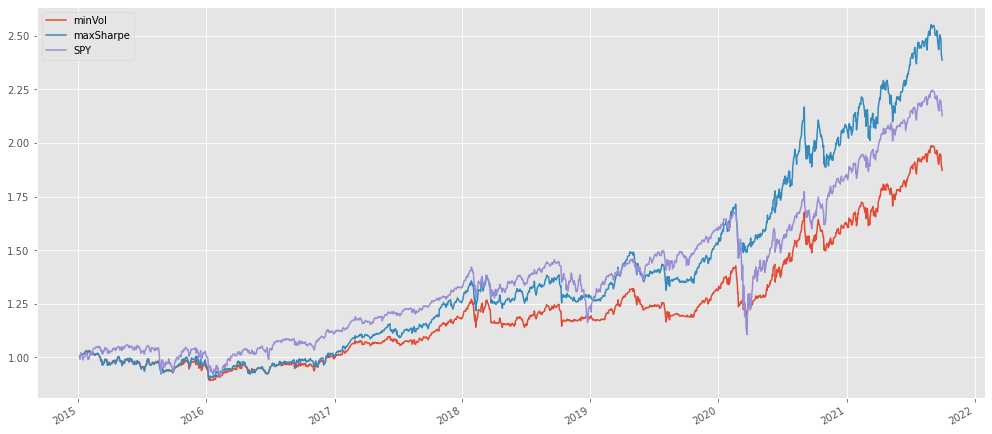

In [11]:
v_stratDf = pd.DataFrame.from_dict(strategies_dict)
print(v_stratDf)

# get the bechmark series
p_folderName='US_benchmarks'    # name of folder where the database is kept 
v_benchList = Stock.getStocksFromFiles(p_database='eikon', p_number=None, p_exchange=p_folderName, p_shuffle=False, data_path='../data')
v_benchPricesDf = Stock.getAssetsAggregatedDf(v_benchList)  
v_benchPricesDf = v_benchPricesDf.loc[v_stratDf.index[0]:v_stratDf.index[-1]]
v_benchPricesDf = v_benchPricesDf / v_benchPricesDf.iloc[0]

# insert benchmark into the dataFrame of all strategies
v_stratDf = pd.concat([v_stratDf, v_benchPricesDf], axis=1)

# plot curves for the best strategies
#v_stratDf = v_stratDf.rebase(1)
strDateFrom = v_dateFrom.strftime('%Y-%m-%d')
strDateTo = v_dateTo.strftime('%Y-%m-%d')
graphTitle = f'Comparison of the best strategies from {strDateFrom} to {strDateTo}'
v_stratDf.plot(figsize=(17,8))

In [15]:
v_stratDf.to_csv("../results/backtest/baseline.csv", index=True)

In [12]:
# calculating the stats for the best strategies 
statsStrat = v_stratDf.calc_stats()
statsStrat.display()

Stat                 minVol      maxSharpe    SPY
-------------------  ----------  -----------  ----------
Start                2015-01-05  2015-01-05   2015-01-05
End                  2021-09-30  2021-09-30   2021-09-30
Risk-free rate       0.00%       0.00%        0.00%

Total Return         87.15%      138.66%      112.74%
Daily Sharpe         0.77        0.92         0.72
Daily Sortino        1.16        1.40         1.07
CAGR                 9.75%       13.79%       11.86%
Max Drawdown         -16.09%     -14.68%      -34.10%
Calmar Ratio         0.61        0.94         0.35

MTD                  -5.48%      -6.01%       -4.97%
3m                   0.70%       1.12%        0.25%
6m                   11.48%      14.22%       8.72%
YTD                  14.91%      14.84%       14.78%
1Y                   20.31%      19.84%       28.14%
3Y (ann.)            14.56%      20.04%       13.74%
5Y (ann.)            14.05%      19.24%       14.69%
10Y (ann.)           -           -        

/home/victormmp/.virtualenvs/rl_mestrado/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/victormmp/.virtualenvs/rl_mestrado/lib/python3.8/site-packages/ffn/core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


In [13]:
### ----------- in case of Errors in the optimization process, try with alternative solvers
#solversList = ['OSQP', 'SCS']

#i_solver = 'OSQP' 
#i_method = 'MaxSharpe'
#i_bound = 0.1

#v_bounds = (0, i_bound)
        
#if i_method == 'minVolatility':
#    i_metStr = 'minVol'
#elif i_method == 'maxSharpe':
#    i_metStr = i_method
#keyName =  f'{i_metStr}_{i_bound}'

#v_errors.pop(0) # remove the first item from v_errors

#try:
#    print(f'--------------------------------------------------------------\n')
#    print(f'Starting Backtesting from {v_dateFrom} to {v_dateTo}\n')
#    print(f'Strategy Name: {keyName} - Solver: {i_solver} \n')
#    print(f'--------------------------------------------------------------\n')

#    v_cumReturnsSeries = PyPortfolioOptimize(p_assets=v_assetsList, 
#                                             p_compositionsSeries=v_compositionsSeries,
#                                             p_dateFrom=v_dateFrom,
#                                             p_dateTo=v_dateTo,
#                                             p_selectByComposition=v_selectByComposition,
#                                             p_selectByReturn=v_selectByReturn,
#                                             p_minAssetLength = v_minAssetLength,  
#                                             verbose=True,
#                                             p_inSamplePeriod=v_inSamplePeriod,
#                                             p_rollingPeriod=v_rollingPeriod,
#                                             p_method=i_method,
#                                             p_bounds=v_bounds,
#                                             p_solver = i_solver)
#    if optimization was successfull, then insert strategy's cumulative returns into dict 
#    strategies_dict[keyName] = v_cumReturnsSeries
    
#except:
#    traceback.print_exc()
#    print(f'Error for {keyName}')
#    v_errors.append(keyName)
        
        
#print(f'Errors for portfolios: {v_errors}')
    
#if len(v_errors) == 0: 
    #save_to_pickle(v_savingPath, strategies_dict)